### 1 Loading Dataset

In [2]:
import shutil
shutil.copytree('/content/drive/MyDrive/Project/image_ontrajectory/', '/content/project_data/')

'/content/project_data/'

In [1]:
from google.colab import drive
import sys
import os

drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/My Drive/Project/')

Mounted at /content/drive


In [3]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import random
import time
import torchvision.transforms as transforms

from my_datasets import MyDataset_CNN, MyDataset_CNN3
from models import MyModel_CNN, MyModel_CNNalex, MyModel_CNNrender


In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

True
cuda:0


In [5]:
#preprocess the txt file
ROOT = '/content/project_data/'
train_out = open(ROOT+"traindata_shuffle_img.txt",'w')
val_out = open(ROOT+"valdata_shuffle_img.txt",'w')
over_out = open(ROOT+"overdata_shuffle_img.txt",'w')
lines=[]
with open(ROOT+"data_transformation.txt", 'r') as infile:
    for line in infile:
        lines.append(line)
    random.shuffle(lines)
    num_train = np.ceil(0.8*len(lines))
    for count, line in enumerate(lines):
        if count <=num_train:
            if count< 4:
                over_out.write(line)
            train_out.write(line)
        else:
            val_out.write(line) 
train_out.close()            
val_out.close()
over_out.close()        

In [6]:
SIZE = (128,128)
TRANSFORM = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 


over_data = MyDataset_CNN3(root = ROOT, txtname = 'overdata_shuffle_img.txt', transform=TRANSFORM, size=SIZE)
train_data = MyDataset_CNN3(root = ROOT, txtname = 'traindata_shuffle_img.txt' , transform = TRANSFORM, size= SIZE)
val_data = MyDataset_CNN3(root = ROOT, txtname = 'valdata_shuffle_img.txt', transform = TRANSFORM, size= SIZE)

over_loader = DataLoader(dataset=over_data, batch_size=4, shuffle=True)
train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True, pin_memory=True, num_workers = 4)
val_loader = DataLoader(dataset=val_data, batch_size=256, shuffle=True, pin_memory=True, num_workers = 4)
# pin_memory=True, num_workers=4

print("Overfit size: %i" % len(over_data))
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))


Overfit size: 4
Train size: 12801
Validation size: 3199


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 128, 128])
4.939488759971131


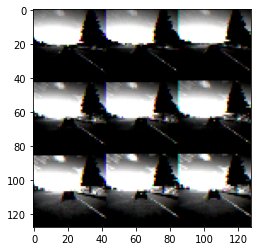

In [7]:
print(over_data[0][0][0].shape)
print(over_data[0][0][1])
#print(over_data[0][0][2])
plt.imshow(over_data[0][0][0].view(128,128,3))

### 2 Defining Neural Network

In [8]:
channel = [128, 128, 128, 64]
kernel = 2
neuron = [64, 32]
stride = 2 

#mynet = MyModel_CNNalex()
#print(mynet)


mynet= MyModel_CNNrender() 
mynet.cuda()
print(mynet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

MyModel_CNNrender(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (predict): Sequential(
    (0): Linear(in_features=258, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
  )
  (pool)

In [9]:
total_params = sum(p.numel() for p in mynet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in mynet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

2,486,467 total parameters.
2,486,467 trainable parameters.


### 3 Training Neural network

In [10]:
#mycriterion = nn.SmoothL1Loss(reduction='mean') 
mycriterion = nn.MSELoss(reduction='mean') 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-4, eps = 1e-08) 

In [11]:
def run_epoch(model,criterion,optimizer,dataloader,iftrain):    
    running_loss = 0.0 
    running_loss0 = 0.0
    running_loss1 = 0.0
    running_loss2 = 0.0 
    
    #Iterating through the minibatches of the data
    for i, data in enumerate(dataloader, 0): 
        X, y = data
        #print(X)
        X = [x.cuda() for x in X]
        #X = X.float().cuda()
        y = y.cuda() 
        
        if iftrain:  
            optimizer.zero_grad()
            y_pred = model(X) 
            y_pred = y_pred.float() 
            y = y.float()
            #loss = criterion(y_pred, y) 
            loss0 = criterion(y_pred[:,0], y[:,0])
            loss1 = criterion(y_pred[:,1], y[:,1])
            loss2 = criterion(y_pred[:,2], y[:,2]) 
            loss = (loss0 + loss1 + loss2*5)/3   
            loss.backward()             
            optimizer.step()
            running_loss += loss.item()
            running_loss0 += loss0.item() 
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()             
            
        else:
            y_pred = model(X)
            y_pred = y_pred.float()  
            y = y.float()
            #loss = criterion(y_pred, y)
            loss0 = criterion(y_pred[:,0], y[:,0])
            loss1 = criterion(y_pred[:,1], y[:,1])
            loss2 = criterion(y_pred[:,2], y[:,2])  
            loss = (loss0 + loss1 + loss2*5 )/3

            running_loss += loss.item()
            running_loss0 += loss0.item() 
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()      
    return running_loss, running_loss0, running_loss1, running_loss2   

In [12]:
# test if the model will overfit with only one sample
max_epochs = 1000
train_history = []
val_history = []
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-4, eps = 1e-08) 
#scheduler = optim.lr_scheduler.CosineAnnealingLR(myoptimizer, max_epochs)
for epoch in range(max_epochs):
    '''
    if epoch >= 1999 and epoch <= 2999:
        myoptimizer.param_groups[0]['lr'] = 1e-5
    elif epoch > 2999:
        myoptimizer.param_groups[0]['lr'] = 1e-6
        
    scheduler.step()
    '''
    start = time.time()
    train_loss,_,_,_ = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=True)
    train_history.append(train_loss)
    val_loss, val_loss0, val_loss1, val_loss2 =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=False)
    val_history.append(val_loss)
    end = time.time()
    if epoch % 50 == 49:
        print('Epoch %.0f / 1000, train_loss: %2e, val_loss: %2e(%2e,%2e,%2e), runtime:% s' % 
              (epoch+1, train_loss, val_loss, val_loss0, val_loss1, val_loss2, end-start))
        #print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %2e, val_loss: %2e " %  (train_loss/4, val_loss/4))
        #print(scheduler.get_last_lr())

Epoch 50 / 1000, train_loss: 3.246346e-03, val_loss: 4.090230e-03(7.505150e-03,4.367195e-03,7.966901e-05), runtime:0.016300678253173828
Epoch 100 / 1000, train_loss: 2.341461e-05, val_loss: 3.092556e-05(4.250769e-05,4.160014e-05,1.733766e-06), runtime:0.015743732452392578
Epoch 150 / 1000, train_loss: 5.929564e-07, val_loss: 8.150193e-07(2.745479e-07,2.048075e-07,3.931405e-07), runtime:0.016004085540771484
Epoch 200 / 1000, train_loss: 3.807011e-08, val_loss: 2.694028e-07(2.140591e-07,7.755293e-08,1.033193e-07), runtime:0.01583242416381836
Epoch 250 / 1000, train_loss: 3.390813e-07, val_loss: 1.106179e-06(1.292099e-07,1.830318e-07,6.012591e-07), runtime:0.016669034957885742
Epoch 300 / 1000, train_loss: 2.354591e-07, val_loss: 1.901765e-06(4.795049e-07,2.509013e-07,9.949780e-07), runtime:0.015738725662231445
Epoch 350 / 1000, train_loss: 2.066616e-06, val_loss: 7.388553e-07(9.557493e-08,1.624894e-07,3.917003e-07), runtime:0.015767812728881836
Epoch 400 / 1000, train_loss: 7.419382e-07,

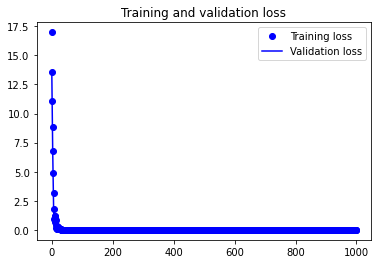

In [13]:
# plot the train&validation loss curve with only one sample
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
plt.plot(epochs, val_history, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [14]:
#TEST = random.randint (0, 3)
for i in range(3):
  test_in, gt_output = over_data[i]
  #print(test_in.shape)
  test_in = [torch.tensor(x).to(device) for x in test_in] 
  #test_in = torch.tensor(test_in).to(device)
  gt_output = torch.tensor(gt_output).to(device)
  mynet.eval() 
  output_pred = mynet(test_in) 
  #print('TEST', TEST)
  #print('test_in',test_in)
  print('prediction:{}, ground truth:{}'.format(output_pred.cpu().detach().numpy(), gt_output.cpu().detach().numpy()))

prediction:[[ 7.585876   -0.21984017 -0.0800949 ]], ground truth:[ 7.58789739 -0.22027061 -0.07652274]
prediction:[[7.0834794  0.73976636 0.19662428]], ground truth:[7.0851681  0.74048299 0.19993098]
prediction:[[6.8272686  0.1932303  0.07089811]], ground truth:[6.82854004 0.19275955 0.07360405]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [15]:
# start the main training process

num_trainbatch = np.ceil(len(train_data)/256) 
num_valbatch = np.ceil(len(val_data)/256) 
train_history = []
val_history = []

min_loss = 100000
current_patience = 0
patience = 10



In [ ]:
! /opt/bin/nvidia-smi

Mon Jan 24 14:11:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    36W / 250W |   2611MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-6, eps = 1e-08) 
max_epochs = 20
best_model= MyModel_CNNrender() 
print('Start training!')
for epoch in range(max_epochs): 
    '''
    if epoch >= 2999 and epoch <= 3999:
        myoptimizer.param_groups[0]['lr'] = 1e-5
    elif epoch > 3999:
        myoptimizer.param_groups[0]['lr'] = 1e-6
    '''
    start = time.time()
    train_loss,_,_,_ = run_epoch(model=mynet, criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=train_loader,
                           iftrain=True)
    train_history.append(train_loss)
    val_loss, val_loss0, val_loss1, val_loss2 =  run_epoch(model=mynet, criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=val_loader,
                           iftrain=False)
    val_history.append(val_loss)
    end = time.time()
    #if epoch % 50 == 49:
    print('Epoch %.0f / 20, train_loss: %2e, val_loss: %2e(%2e,%2e,%2e), runtime:% s' % 
              (epoch+1, train_loss/num_trainbatch, val_loss/num_valbatch, val_loss0/num_valbatch, val_loss1/num_valbatch, val_loss2/num_valbatch, end-start))

'''
    # early stopping
    if min_loss == 100000 or val_loss < min_loss :
        min_loss = val_loss
        current_patience = 0
        best_model = mynet
        #torch.save(mynet.state_dict(),'mynet.pth')
      
    else :
        current_patience += 1 
        if current_patience >= patience :
            print("Stopping early at epoch {}!".format(epoch+1)) 
            break   
'''
print('FINISH.')
# save trained model
#torch.save(mynet.state_dict(),'/content/drive/My Drive/Project/mynet_cnn_img.pth')
#('model saved')

Start training!
Epoch 1 / 20, train_loss: 9.996351e-03, val_loss: 2.182421e-02(2.837611e-02,2.906143e-02,1.607015e-03), runtime:20.80856466293335
Epoch 2 / 20, train_loss: 9.856370e-03, val_loss: 2.134601e-02(2.713088e-02,2.892129e-02,1.597175e-03), runtime:20.330759048461914
Epoch 3 / 20, train_loss: 9.768726e-03, val_loss: 2.189582e-02(2.754573e-02,3.007965e-02,1.612418e-03), runtime:20.610572338104248
Epoch 4 / 20, train_loss: 9.718654e-03, val_loss: 2.178635e-02(2.776081e-02,2.943077e-02,1.633491e-03), runtime:20.36743664741516
Epoch 5 / 20, train_loss: 9.901728e-03, val_loss: 2.154119e-02(2.737251e-02,2.903713e-02,1.642785e-03), runtime:20.284652948379517
Epoch 6 / 20, train_loss: 9.815264e-03, val_loss: 2.164197e-02(2.733355e-02,2.953360e-02,1.611753e-03), runtime:20.444802045822144
Epoch 7 / 20, train_loss: 9.770257e-03, val_loss: 2.177508e-02(2.767909e-02,2.951164e-02,1.626898e-03), runtime:20.351157188415527
Epoch 8 / 20, train_loss: 9.683262e-03, val_loss: 2.156252e-02(2.7733

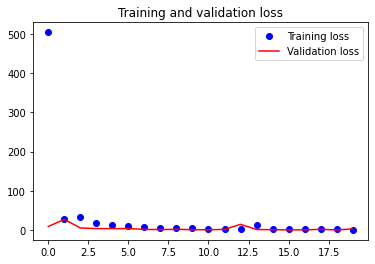

In [17]:
 # plot the train&validation loss curve 
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
plt.plot(epochs, val_history, 'r', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()


In [27]:
# save trained model
torch.save(mynet.state_dict(),'/content/drive/My Drive/Project/mynet_cnn_ontraj3.pth')

In [ ]:
mynet.load_state_dict(torch.load('/content/drive/My Drive/Project/mynet_cnn_render2.pth'))
#, map_location='cpu'

<All keys matched successfully>

In [24]:
for i in range(30):
  TEST = random.randint (0, 100)
  test_in, gt_output = val_data[TEST]
  test_in = [torch.tensor(x).to(device) for x in test_in]
  #test_in = torch.tensor(test_in).to(device)
  gt_output = torch.tensor(gt_output).to(device)
  output_pred = mynet(test_in) 
  #print('TEST', TEST)
  #print('test_in',test_in)
  print('prediction:{}, ground truth:{}'.format(output_pred.cpu().detach().numpy(), gt_output.cpu().detach().numpy()))

prediction:[[10.339749   -0.77280015 -0.11049652]], ground truth:[10.17517582 -0.86586602 -0.09571008]
prediction:[[7.6320286  0.25988033 0.04510578]], ground truth:[7.78193066 0.48750083 0.10924926]
prediction:[[ 7.3506165  -0.01357924 -0.02396864]], ground truth:[ 7.45445437e+00 -6.10606030e-02  7.32369300e-05]
prediction:[[6.9623756  0.0571394  0.01069781]], ground truth:[6.78853788 0.00774781 0.0257859 ]
prediction:[[7.652865   0.02895946 0.01331398]], ground truth:[ 7.64670316e+00 -1.76966649e-02  3.41683568e-04]
prediction:[[5.7436767 2.8251016 0.6895134]], ground truth:[5.83714603 3.10188577 0.85021697]
prediction:[[ 6.7491956e+00  3.4633942e-02 -4.3791905e-04]], ground truth:[6.78592838 0.03383464 0.01581465]
prediction:[[ 6.98732    -0.2796548  -0.07356352]], ground truth:[ 7.01240869 -0.15741279 -0.0553831 ]
prediction:[[ 7.5113921e+00  1.6038008e-02 -1.8409528e-03]], ground truth:[ 7.47660145 -0.00807178 -0.02342423]
prediction:[[13.884867   -1.7590063  -0.20739865]], ground

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
